# Analyzing TCR data
![dandelion_logo](img/dandelion_logo_illustration.png)

With `dandelion>=1.3` onwards, there will be the ability to start analyzing 10x single-cell TCR data with the existing setup for both alpha-beta and gamma-delta TCR data formats. Currently, the alpha-beta and gamma-delta data sets have to be analyzed separately.

The workflow may be a bit buggy because it's not optimised for TCR data; do let me know if you find any bugs and I can see if i can try to fix the issue(s).

We will download the various input formats of TCR files from 10x's [resource page](https://www.10xgenomics.com/resources/datasets) as part of this tutorial:

```bash
# bash
mkdir -p dandelion_tutorial/sc5p_v2_hs_PBMC_10k;
mkdir -p dandelion_tutorial/sc5p_v1p1_hs_melanoma_10k;

cd dandelion_tutorial/sc5p_v2_hs_PBMC_10k;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_airr_rearrangement.tsv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_filtered_contig_annotations.csv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_filtered_contig.fasta;

cd ../sc5p_v1p1_hs_melanoma_10k;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_airr_rearrangement.tsv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_filtered_contig_annotations.csv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_filtered_contig.fasta;
```

**Import *dandelion* module**

In [1]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_versions()

dandelion==0.2.2 pandas==1.2.3 numpy==1.21.0 matplotlib==3.3.4 networkx==2.6 scipy==1.7.0


I'm showing two examples for reading in the data: with or without reannotation.

**Read in AIRR format**

In [2]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))

In [3]:
# read in the airr_rearrangement.tsv file
file1 = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_airr_rearrangement.tsv'
file2 = 'sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_airr_rearrangement.tsv'

In [4]:
vdj1 = ddl.read_10x_airr(file1)
vdj1

Dandelion class object with n_obs = 5351 and n_contigs = 10860
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VJ_2', 'duplicate_count_VDJ_2', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'locus_status', 'productive_status', 'rearrangement_VDJ_status'

In [5]:
vdj2 = ddl.read_10x_airr(file2)
vdj2

Dandelion class object with n_obs = 1560 and n_contigs = 2755
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VJ_2', 'duplicate_count_VDJ_2', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'locus_status', 'productive_status', 'rearrangement_VDJ_status',

In [6]:
# combine into a singular object
# let's add the sample_id to each cell barcode so that we don't end up overlapping later on
sample_id = 'sc5p_v2_hs_PBMC_10k'
vdj1.data['sample_id'] = sample_id
vdj1.data['cell_id'] = [sample_id + '_' + c for c in vdj1.data['cell_id']]
vdj1.data['sequence_id'] = [sample_id + '_' + s for s in vdj1.data['sequence_id']]

sample_id = 'sc5p_v1p1_hs_melanoma_10k'
vdj2.data['sample_id'] = sample_id
vdj2.data['cell_id'] = [sample_id + '_' + c for c in vdj2.data['cell_id']]
vdj2.data['sequence_id'] = [sample_id + '_' + s for s in vdj2.data['sequence_id']]

# combine into a singular object
vdj = ddl.concat([vdj1, vdj2])
vdj

Dandelion class object with n_obs = 6911 and n_contigs = 13615
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VJ_2', 'duplicate_count_VDJ_2', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'locus_status', 'productive_status', 

**Read in with reannotation**

We specify the `filename_prefix` option because they have different prefixes that precedes `_contig.fasta` and `_contig_annotations.csv`.

In [6]:
samples = ['sc5p_v2_hs_PBMC_10k', 'sc5p_v1p1_hs_melanoma_10k']
filename_prefixes = ['sc5p_v2_hs_PBMC_10k_t_filtered', 'sc5p_v1p1_hs_melanoma_10k_t_filtered']
ddl.pp.format_fastas(samples, prefix = samples, filename_prefix = filename_prefixes)

Formating fasta(s) : 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


Make sure to toggle `loci = 'tr'` for TCR data. I'm setting `reassign_dj = True` so as to try and force a reassignment of J genes (and D genes if it can) with stricter cut offs.

In [7]:
ddl.pp.reannotate_genes(samples, loci = 'tr', reassign_dj = True, filename_prefix = filename_prefixes)

Assigning genes : 100%|██████████| 2/2 [07:26<00:00, 223.16s/it]


There's no need to run the the rest of the preprocessing steps.

We'll read in the reannotated files like as follow:

In [9]:
import pandas as pd
tcr_files = []
for sample in samples:
    file_location = sample +'/dandelion/' + sample + '_t_filtered_contig_dandelion.tsv'
    tcr_files.append(pd.read_csv(file_location, sep = '\t'))
tcr = tcr_files[0].append(tcr_files[1:])
tcr.reset_index(inplace = True, drop = True)
tcr

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,fwr2_aa,fwr3_aa,fwr4_aa,cdr1_aa,cdr2_aa,cdr3_aa,sequence_alignment_aa,v_sequence_alignment_aa,d_sequence_alignment_aa,j_sequence_alignment_aa
0,sc5p_v2_hs_PBMC_10k_CAGGTGCCAGGAACGT_contig_1,ACTTCTTAGTGCCTTTTCTCAGGGGAGAGGCCATCACTTGAAGATG...,F,T,TRBV29-1*01,NaN,TRBJ2-7*01,AGTGCTGTCATCTCTCAAAAGCCAAGCAGGGATATCTGTCAACGTG...,AGTGCTGTCATCTCTCAAAAGCCAAGCAGGGATATCTGTCAACGTG...,TGCAGCGTTGCGGAGACAGGAATTGTCTACGAGCAGTACTTC,...,MFWYRQQPGQSLTLIAT,TYESGFVIDKFPISRPNLTFSTLTVSNMSPEDSSIYLC,FGPGTRLTVT,SQVTM,ANQGSEA,SVAETGIVYEQY,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,NaN,YEQYFGPGTRLTVT
1,sc5p_v2_hs_PBMC_10k_GGCGACTAGAGTACAT_contig_2,CAGCGTTTCTTATATGGGGACAGTGACACTGATCTGGTAAAGCCCC...,F,T,TRBV7-7*01,TRBD2*01,TRBJ2-2*01,GGTGCTGGAGTCTCCCAGTCTCCCAGGTACAAAGTCACAAAGAGGG...,GGTGCTGGAGTCTCCCAGTCTCCCAGGTACAAAGTCACAAAGAGGG...,TGTGCCAGCAGCGAAGGAGCGGGGGGGAACACCGGGGAGCTGTTTTTT,...,LYWYQQALGQGPEFLTY,PDKSGLPSDRFSAERPEGSISTLTIQRTEQRDSAMYRC,FGEGSRLTVL,SSHAT,FNYEAQ,ASSEGAGGNTGELF,GAGVSQSPRYKVTKRGQDVTLRCDPISSHATLYWYQQALGQGPEFL...,GAGVSQSPRYKVTKRGQDVTLRCDPISSHATLYWYQQALGQGPEFL...,AGG,NTGELFFGEGSRLTVL
2,sc5p_v2_hs_PBMC_10k_CAGCTAACAATCGGTT_contig_2,ACAGTGATCCTGATCTGGTAAAGCTCCCATCCTGCCCTGACCCTGC...,F,T,TRBV7-2*01,NaN,TRBJ2-7*01,GGAGCTGGAGTCTCCCAGTCCCCCAGTAACAAGGTCACAGAGAAGG...,GGAGCTGGAGTCTCCCAGTCCCCCAGTAACAAGGTCACAGAGAAGG...,TGTGCCAGCAGCTTAGCGGGGATAGAGACCTACGAGCAGTACTTC,...,LYWYRQSLGQGLEFLIY,PDKSGLPSDRFSAERTGGSVSTLTIQRTQQEDSAVYLC,FGPGTRLTVT,SGHTA,FQGNSA,ASSLAGIETYEQY,GAGVSQSPSNKVTEKGKDVELRCDPISGHTALYWYRQSLGQGLEFL...,GAGVSQSPSNKVTEKGKDVELRCDPISGHTALYWYRQSLGQGLEFL...,NaN,YEQYFGPGTRLTVT
3,sc5p_v2_hs_PBMC_10k_CCGTTCAAGCTAACAA_contig_2,ATCAATGCACAGATACAGAAGACCCCTCCGTCCTGGAGCACCTGCC...,F,T,TRBV6-6*02,NaN,TRBJ1-4*01,AATGCTGGTGTCACTCAGACCCCAAAATTCCGCATCCTGAAGATAG...,AATGCTGGTGTCACTCAGACCCCAAAATTCCGCATCCTGAAGATAG...,TGTGCCAGCAGTTATCAGGGAGGGGGTGAAAAACTGTTTTTT,...,MYWYRQDPGMGLKLIYY,TDKGEVPNGYNVSRSTTEDFPLRLELAAPSQTSVYFC,FGSGTQLSVL,MNHNY,SVGAGI,ASSYQGGGEKLF,NAGVTQTPKFRILKIGQSMTLQCAQDMNHNYMYWYRQDPGMGLKLI...,NAGVTQTPKFRILKIGQSMTLQCAQDMNHNYMYWYRQDPGMGLKLI...,NaN,EKLFFGSGTQLSVL
4,sc5p_v2_hs_PBMC_10k_GCATACAAGGGTGTTG_contig_2,TTCCTCTGCTCTGGCAGCAGATCTCCCAGAGGGAGCAGCCTGACCA...,F,T,TRBV30*01,NaN,TRBJ2-5*01,TCTCAGACTATTCATCAATGGCCAGCGACCCTGGTGCAGCCTGTGG...,TCTCAGACTATTCATCAATGGCCAGCGACCCTGGTGCAGCCTGTGG...,TGTGCCTGGAGCATGAGCGTACGGGGCAGAGGGGAGACCCAGTACTTC,...,LYWYRQAAGRGLQLLFY,QISSEVPQNLSASRPQDRQFILSSKKLLLSDSGFYLC,FGPGTRLLVL,GTSNPN,SVGIG,AWSMSVRGRGETQY,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGLQL...,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGLQL...,NaN,ETQYFGPGTRLLVL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15458,sc5p_v1p1_hs_melanoma_10k_TGGGCGTCAATGGATA_con...,GAGAAGCCTCACACAGCCCAGTAACTTTGCTAGTACCTCTTGAGTG...,F,F,TRAV19*01,NaN,TRAJ42*01,GCTCAGAAGGTAACTCAAGCGCAGACTGAAATTTCTGTGGTGGAGA...,GCTCAGAAGGTAACTCAAGCGCAGACTGAAATTTCTGTGGTGGAGA...,TGTGCTCTGAGTCTTATGGAGGAAGCCAAGGAAATCTCATCTTT,...,LFWYKQPPSGELVFLIR,EISGRYSWNFQKSTSSFNFTITASQVVDSAVYFC,LEKALNSLLN,TRDTTYY,RNSFDEQN,ALSLMEEAKEISS,AQKVTQAQTEISVVEKEDVTLDCVYETRDTTYYLFWYKQPPSGELV...,AQKVTQAQTEISVVEKEDVTLDCVYETRDTTYYLFWYKQPPSGELV...,NaN,MEEAKEISSLEKALNSLLNQ
15459,sc5p_v1p1_hs_melanoma_10k_TGGGCGTCATCCCATC_con...,AAGATCCTGACAACAACACAATGAGAGCTGCACTCCTTGCAAGTCT...,F,F,TRAV26-1*02,NaN,TRAJ50*01,GATGCTAAGACCACCCAG...CCCACCTCCATGGATTGCGCTGAAG...,GATGCTAAGACCACCCAG...CCCACCTCCATGGATTGCGCTGAAG...,TGCATCGTCAGAGTTTGAAAACCTCCTACGACAAGGTGATATTT,...,VYWYRQIHSQGPQYIIH,ETNEMASLIITEDRKSSTLILPHATLRDTAVYYC,LGQGQAYQSF,TISGNEY,GLKNN,IVRV*KPPTTR*,DAKTTQPTSMDCAEGRAANLPCNHSTISGNEYVYWYRQIHSQGPQY...,DAKTTQPTSMDCAEGRAANLPCNHSTISGNEYVYWYRQIHSQGPQY...,NaN,*KPPTTR*YLGQGQAYQSFQ
15460,sc5p_v1p1_hs_melanoma_10k_TGTGTTTAGATCCCAT_con...,CTGGAAGACCACCTGGGCTGTCATTGAGCTCTGGTGCCAGGAGGAA...,F,F,TRAV23/DV6*01,NaN,TRAJ30*01,CAGCAGCAGGTGAAACAAAGTCCTCAATCTTTGATAGTCCAGAAAG..

The reannotated file can be used with dandelion as per the BCR tutorial.

For the rest of the tutorial, I'm going to show how to proceed with 10x's AIRR format file instead as there are some minor differences.

**Import modules for use with scanpy**

In [10]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata as ad

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.21.5 scipy==1.7.3 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.4


**Import the transcriptome data**

In [11]:
gex_files = {    
    'sc5p_v2_hs_PBMC_10k':'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5',
    'sc5p_v1p1_hs_melanoma_10k':'sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_filtered_feature_bc_matrix.h5'
}

In [12]:
adata_list = []
for f in gex_files:
    adata_tmp = sc.read_10x_h5(gex_files[f], gex_only=True)
    adata_tmp.obs['sample_id'] = f
    adata_tmp.obs_names = [f + '_' + x for x in adata_tmp.obs_names]
    adata_tmp.var_names_make_unique()
    adata_list.append(adata_tmp)
adata = ad.concat(adata_list)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id'

**Run QC on the transcriptome data.**

In [13]:
ddl.pp.recipe_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna'

**Filtering TCR data.**

Note that I'm using the `Dandelion` object as input rather than the pandas dataframe (yes both types of input will works. In fact, a file path to the .tsv will work too).

In [14]:
# The function will return both objects. 
vdj, adata = ddl.pp.filter_contigs(vdj, adata)

Preparing data: 13615it [00:03, 3502.09it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 6911/6911 [00:48<00:00, 142.02it/s]


Finishing up filtering
Initializing Dandelion object


**Check the output V(D)J table**

In [15]:
vdj

Dandelion class object with n_obs = 4886 and n_contigs = 9021
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'umi_count'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'locus_status', 'productive_status', 'rearrangement_VDJ_status', 'rearrang

**Check the AnnData object as well**

In [16]:
adata

AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig'

**The number of cells that actually has a matching BCR can be tabluated.**

In [17]:
pd.crosstab(adata.obs['has_contig'], adata.obs['filter_contig'])

filter_contig,False,True
has_contig,,
No_contig,6971,3456
True,4981,1867


In [18]:
pd.crosstab(adata.obs['has_contig'], adata.obs['contig_QC_pass'])

contig_QC_pass,False,No_contig,True
has_contig,,,
No_contig,0,10427,0
True,1962,0,4886


In [19]:
pd.crosstab(adata.obs['contig_QC_pass'], adata.obs['filter_contig'])

filter_contig,False,True
contig_QC_pass,,
False,95,1867
No_contig,6971,3456
True,4886,0


**Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data**

Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here. The following is just a standard scanpy workflow.

In [20]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

**Identify highly-variable genes**

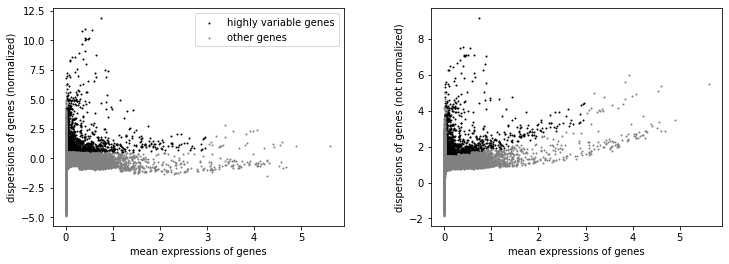

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

**Filter the genes to only those marked as highly-variable**

In [22]:
adata = adata[:, adata.var.highly_variable]

**Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.**

In [23]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'is_doublet' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'filter_rna' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'has_contig' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'filter_contig_quality' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'filter_contig_VDJ' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'filter_contig_VJ' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'contig_QC_pass' as categorical


**Run PCA**

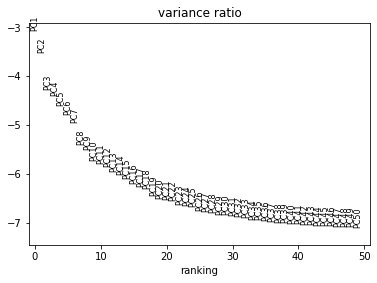

In [24]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

**Computing the neighborhood graph, umap and clusters**

In [25]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# Embedding the neighborhood graph
sc.tl.umap(adata)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

**Visualizing the clusters and whether or not there's a corresponding contig**.

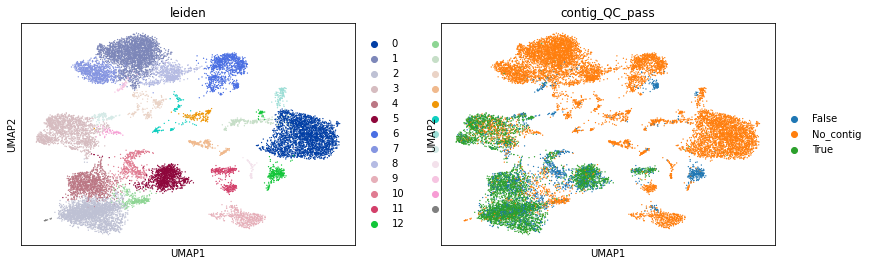

In [26]:
sc.pl.umap(adata, color=['leiden', 'contig_QC_pass'])

**Visualizing some T cell genes.**

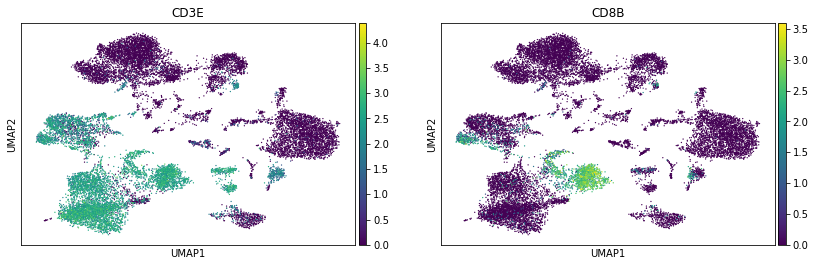

In [27]:
sc.pl.umap(adata, color=['CD3E', 'CD8B'])

**Find clones.**

Here we specify `identity = 1` so only cells with identical CDR3 nucleotide sequences (`key = 'junction'`) are grouped into clones/clonotypes. The current function will only define `ig` or `tr` clonotypes separately, toggled by the `locus` function.

In [28]:
ddl.tl.find_clones(vdj, identity = 1, key = 'junction', locus = 'tr')
vdj

Finding clones based on VDJ chains : 100%|██████████| 498/498 [00:00<00:00, 1592.84it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 4886/4886 [00:00<00:00, 344832.06it/s]


Dandelion class object with n_obs = 4886 and n_contigs = 9021
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'umi_count', 'clone_id'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'locus_status', 'productive_st

**Generate TCR network.**

The 10x-provided AIRR file is missing columns like `sequence_alignment` and `sequence_alignment_aa` so we will use the next best thing, which is `sequence` or `sequence_aa`. Note that these columns are not-gapped.

Specify `key = 'sequence_aa'` to toggle this behavior. Can also try `junction` or `junction_aa` if just want to visualise the CDR3 linkage.

In [29]:
ddl.tl.generate_network(vdj, key = 'sequence_aa')

Setting up data: 9021it [00:01, 4643.42it/s]
Linking edges : 100%|██████████| 4839/4839 [00:00<00:00, 44874.49it/s]


generating network layout


In [30]:
vdj

Dandelion class object with n_obs = 4886 and n_contigs = 9021
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'umi_count', 'clone_id'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'locus_status', 'productive_st

**Plotting in `scanpy`.**

In [31]:
ddl.tl.transfer(adata, vdj) # this will include singletons. To show only expanded clones, specify expanded_only=True

converting matrices
Updating anndata slots


... storing 'clone_id' as categorical
... storing 'locus_VDJ' as categorical
... storing 'locus_VJ' as categorical
... storing 'productive_VDJ' as categorical
... storing 'productive_VJ' as categorical
... storing 'v_call_VDJ' as categorical
... storing 'v_call_VJ' as categorical
... storing 'd_call_VDJ' as categorical
... storing 'j_call_VDJ' as categorical
... storing 'j_call_VJ' as categorical
... storing 'c_call_VDJ' as categorical
... storing 'c_call_VJ' as categorical
... storing 'duplicate_count_VDJ' as categorical
... storing 'duplicate_count_VJ' as categorical
... storing 'junction_VDJ' as categorical
... storing 'junction_VJ' as categorical
... storing 'junction_aa_VDJ' as categorical
... storing 'junction_aa_VJ' as categorical
... storing 'locus_status' as categorical
... storing 'productive_status' as categorical
... storing 'rearrangement_VDJ_status' as categorical
... storing 'rearrangement_VJ_status' as categorical
... storing 'constant_VDJ_status' as categorical
... sto

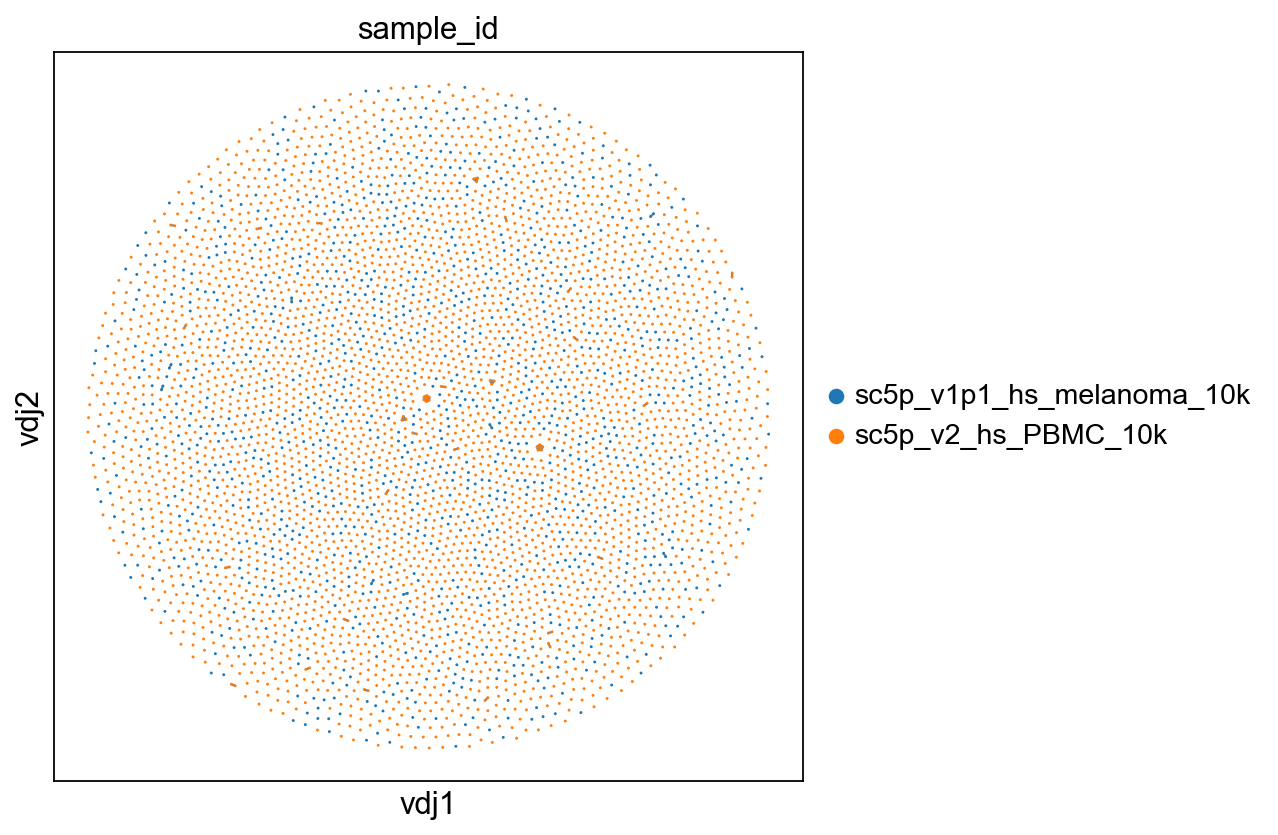

In [32]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['sample_id'], 
                     edges_width = 1) 

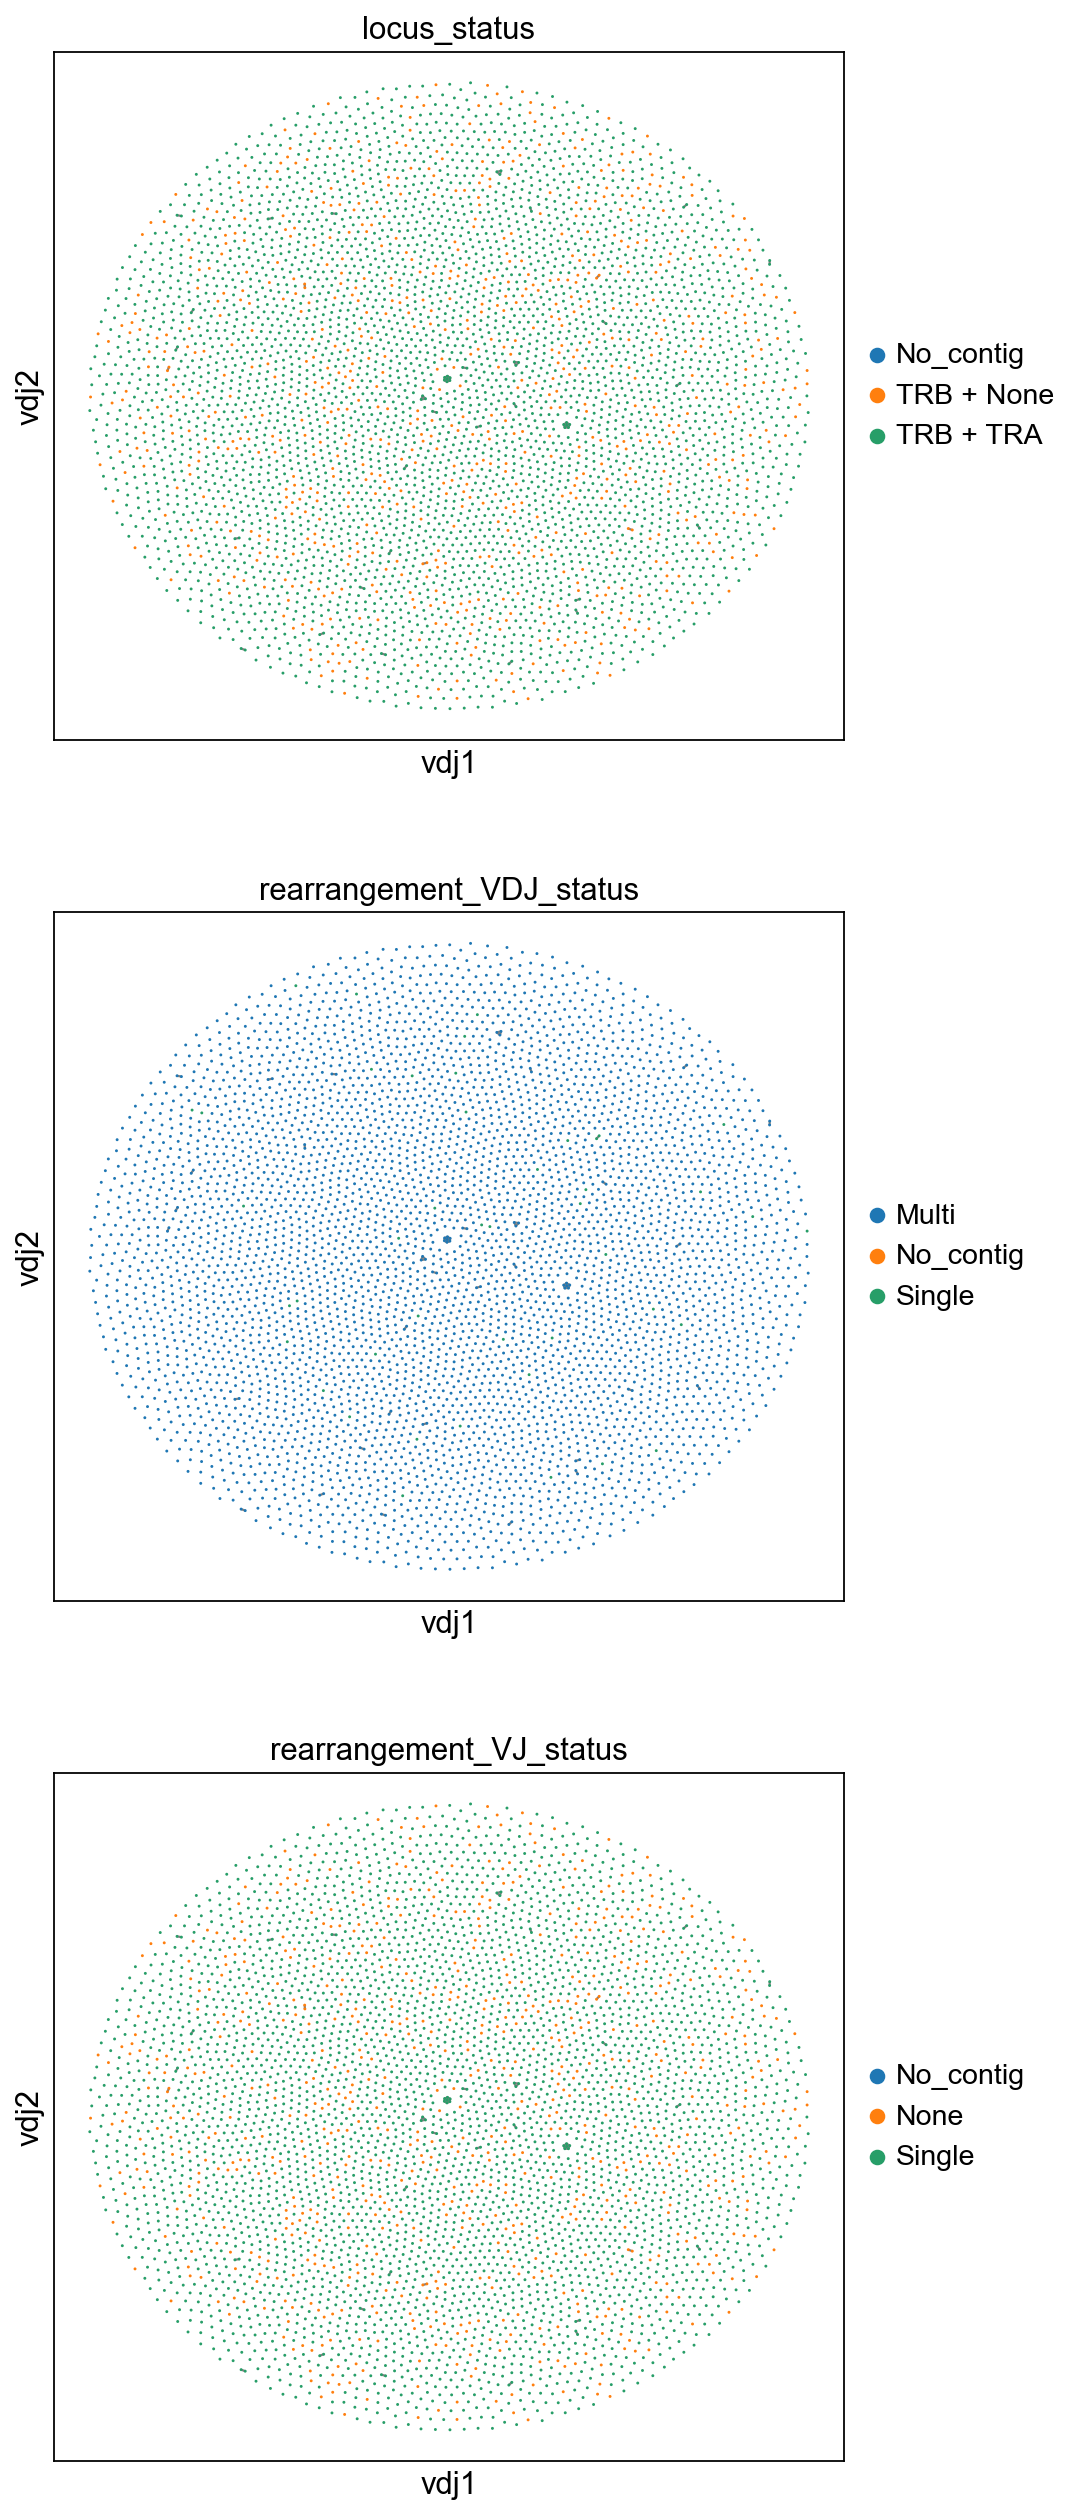

In [33]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['locus_status', 'rearrangement_VDJ_status', 'rearrangement_VJ_status'], 
                     ncols = 1, 
                     legend_fontoutline=3, 
                     edges_width = 1)

In [34]:
ddl.tl.transfer(adata, vdj, expanded_only = True)

converting matrices
Updating anndata slots


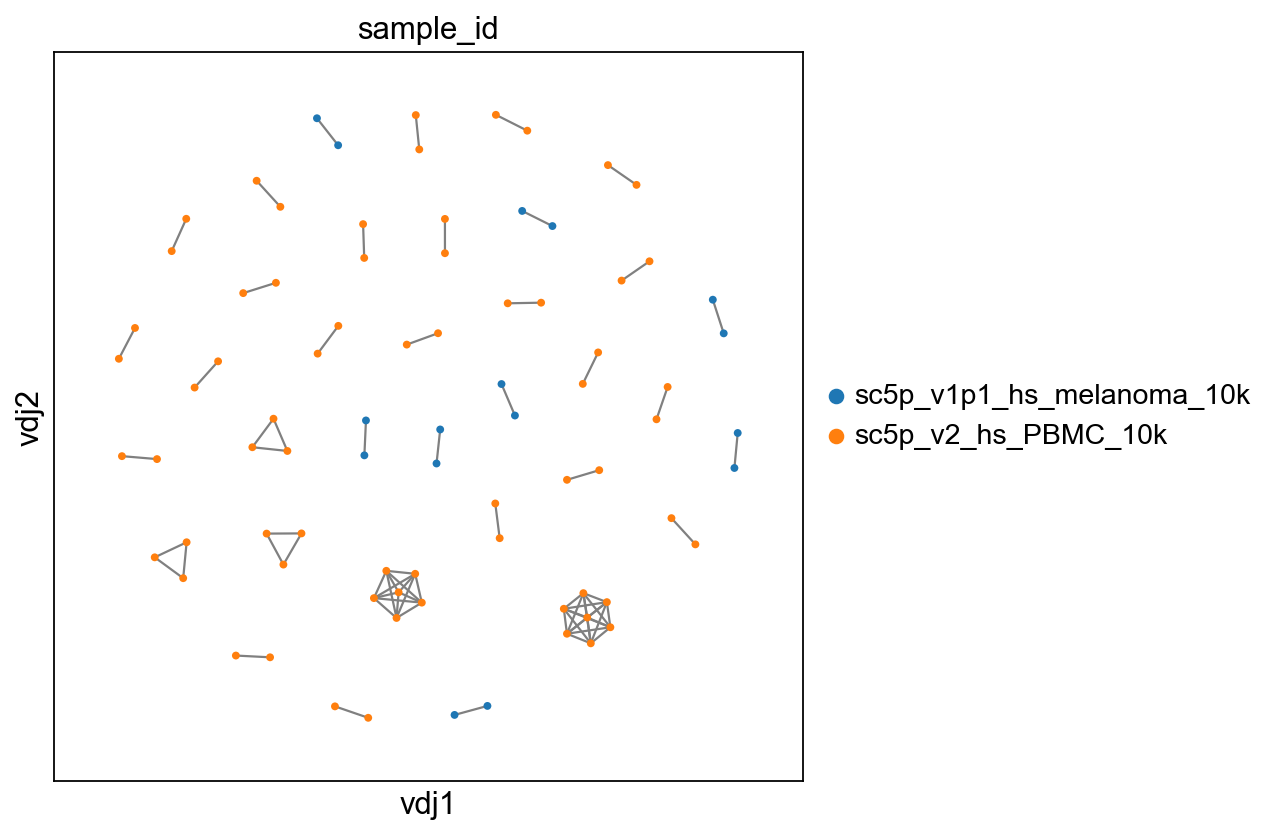

In [35]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['sample_id'], 
                     edges_width = 1,
                     size = 50) 

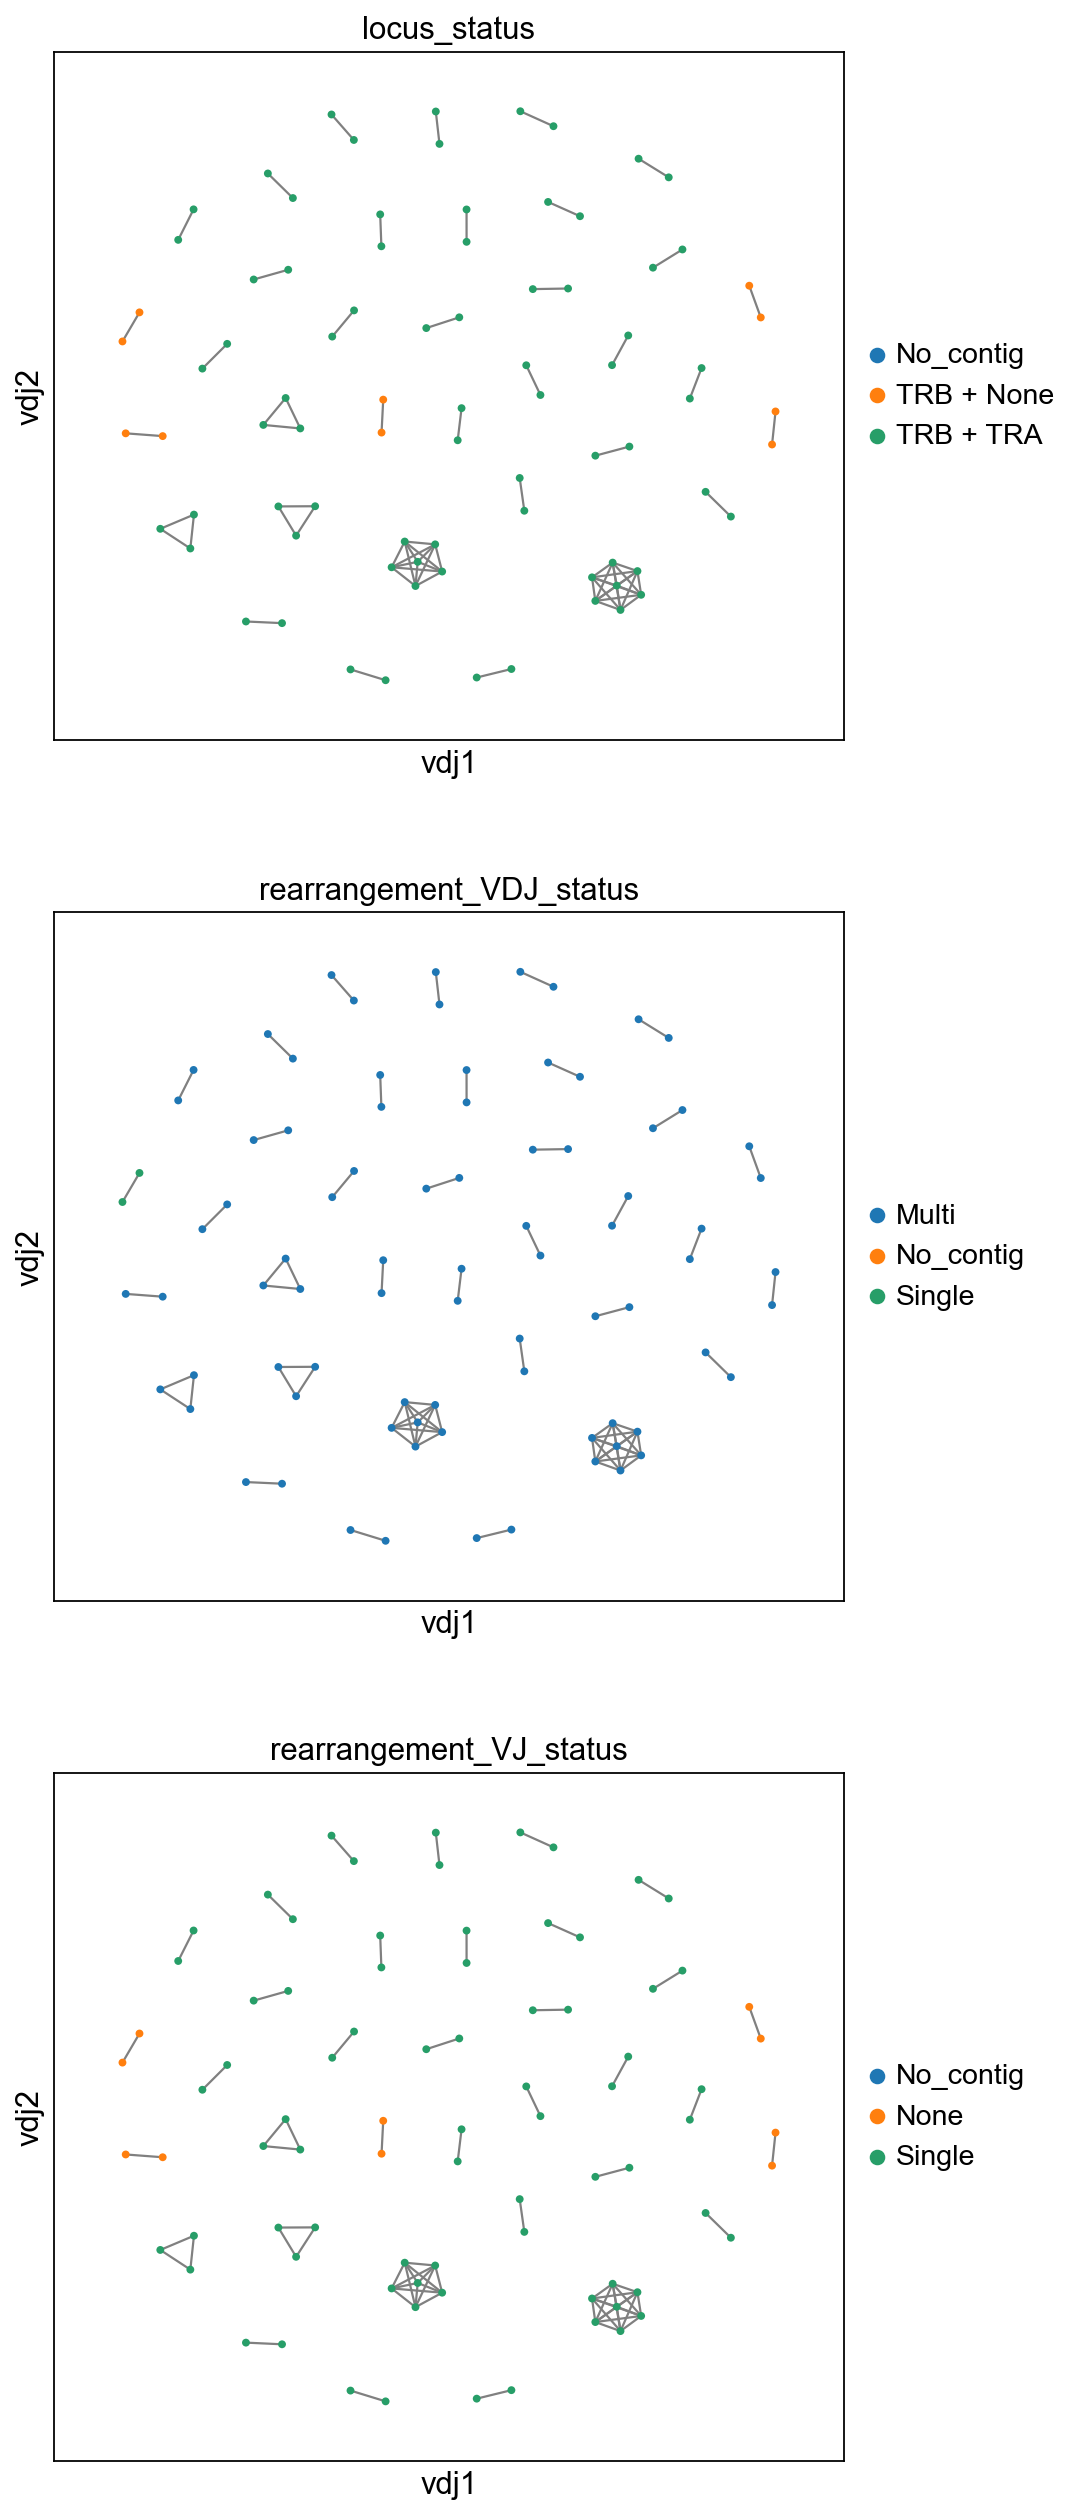

In [36]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['locus_status', 'rearrangement_VDJ_status', 'rearrangement_VJ_status'], 
                     ncols = 1, 
                     legend_fontoutline=3, 
                     edges_width = 1,
                     size = 50)

### Using `scirpy` to plot
You can also use `scirpy`'s functions to plot the network. 

A likely use case is if you have a lot of cells and you don't want to wait for `dandelion` to generate the layout because it's taking too long. Or you simply prefer scirpy's style of plotting.

You can run `ddl.tl.generate_network(..., generate_layout = False)` and it will finish ultra-fast, and after transfer to `scirpy`, you can use its plotting functions to visualise the networks - the clone network is generated very quickly but visualising it using spring layout does take quite a while.

<AxesSubplot:>

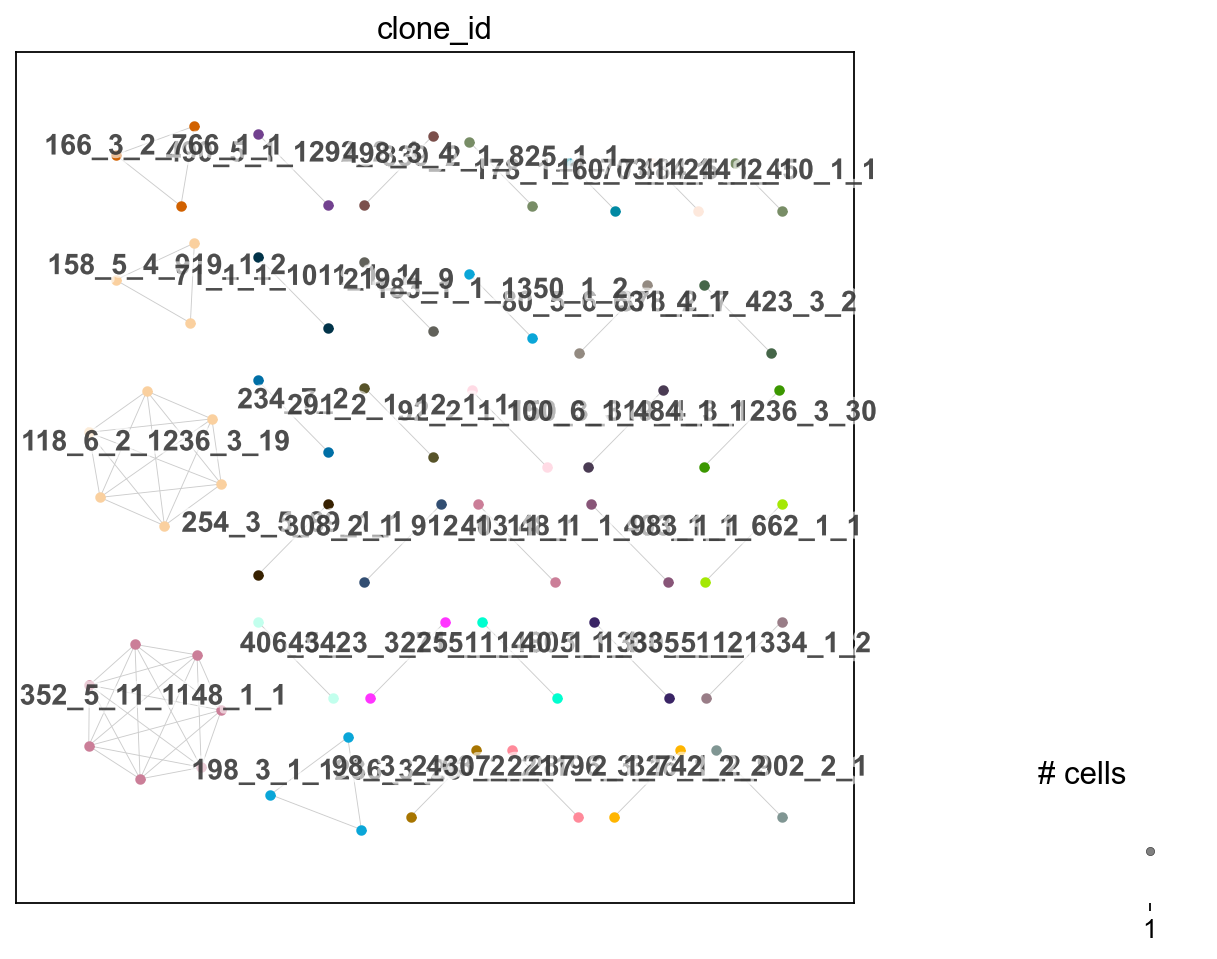

In [37]:
import scirpy as ir
ir.tl.clonotype_network(adata, min_cells = 2)
ir.pl.clonotype_network(adata, color = 'clone_id', panel_size=(7, 7))

You can change the clonotype labels by transferring with a different `clone_key`. For example, from numerically ordered from largest to smallest.

converting matrices
Updating anndata slots


<AxesSubplot:>

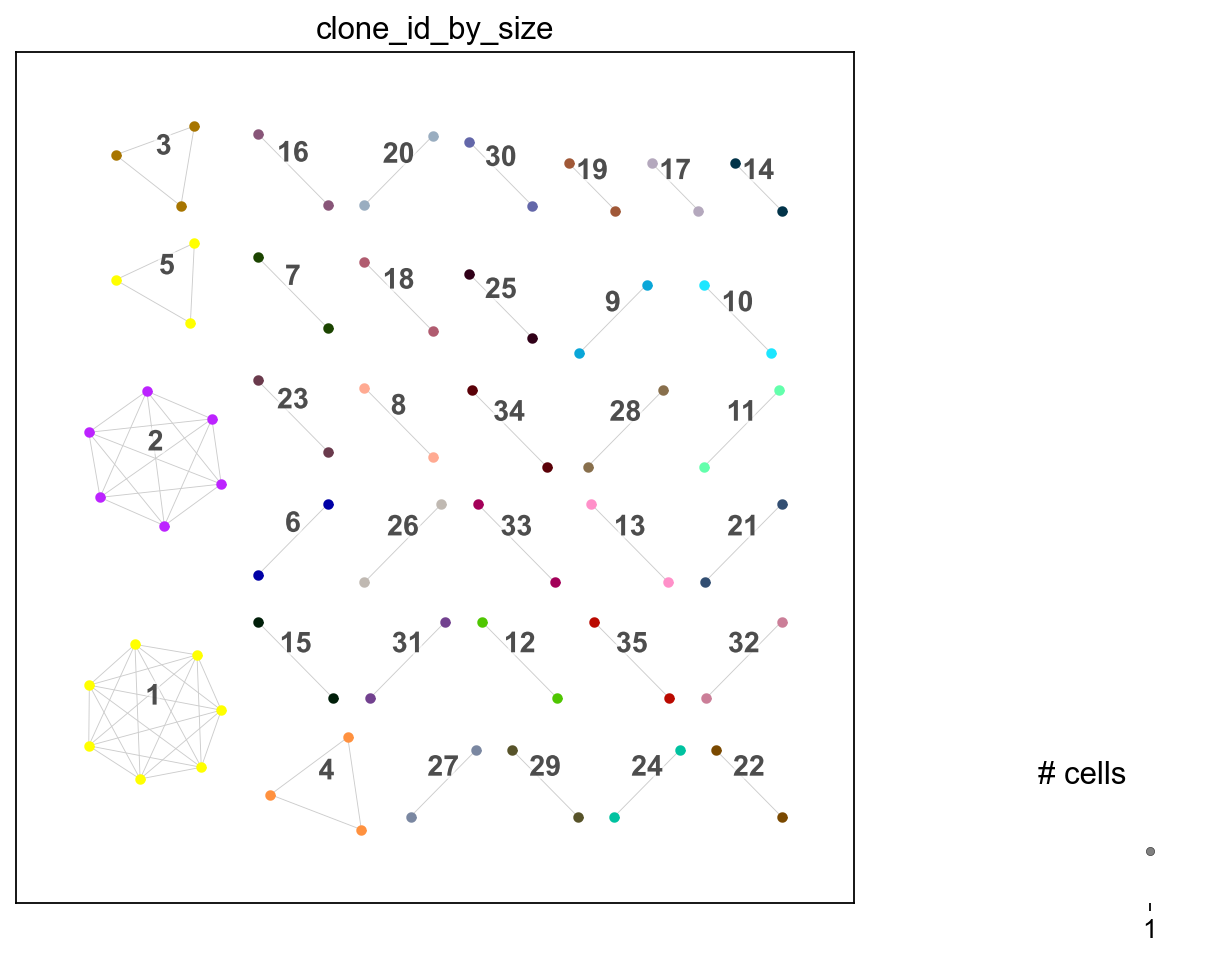

In [38]:
ddl.tl.transfer(adata, vdj, clone_key = 'clone_id_by_size')
ir.tl.clonotype_network(adata, clonotype_key = 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(adata, color = 'clone_id_by_size', panel_size=(7, 7))

You can also transfer with the clones collapsed for plotting as pie-charts as per how `scirpy` does it.

converting matrices
Updating anndata slots


<AxesSubplot:>

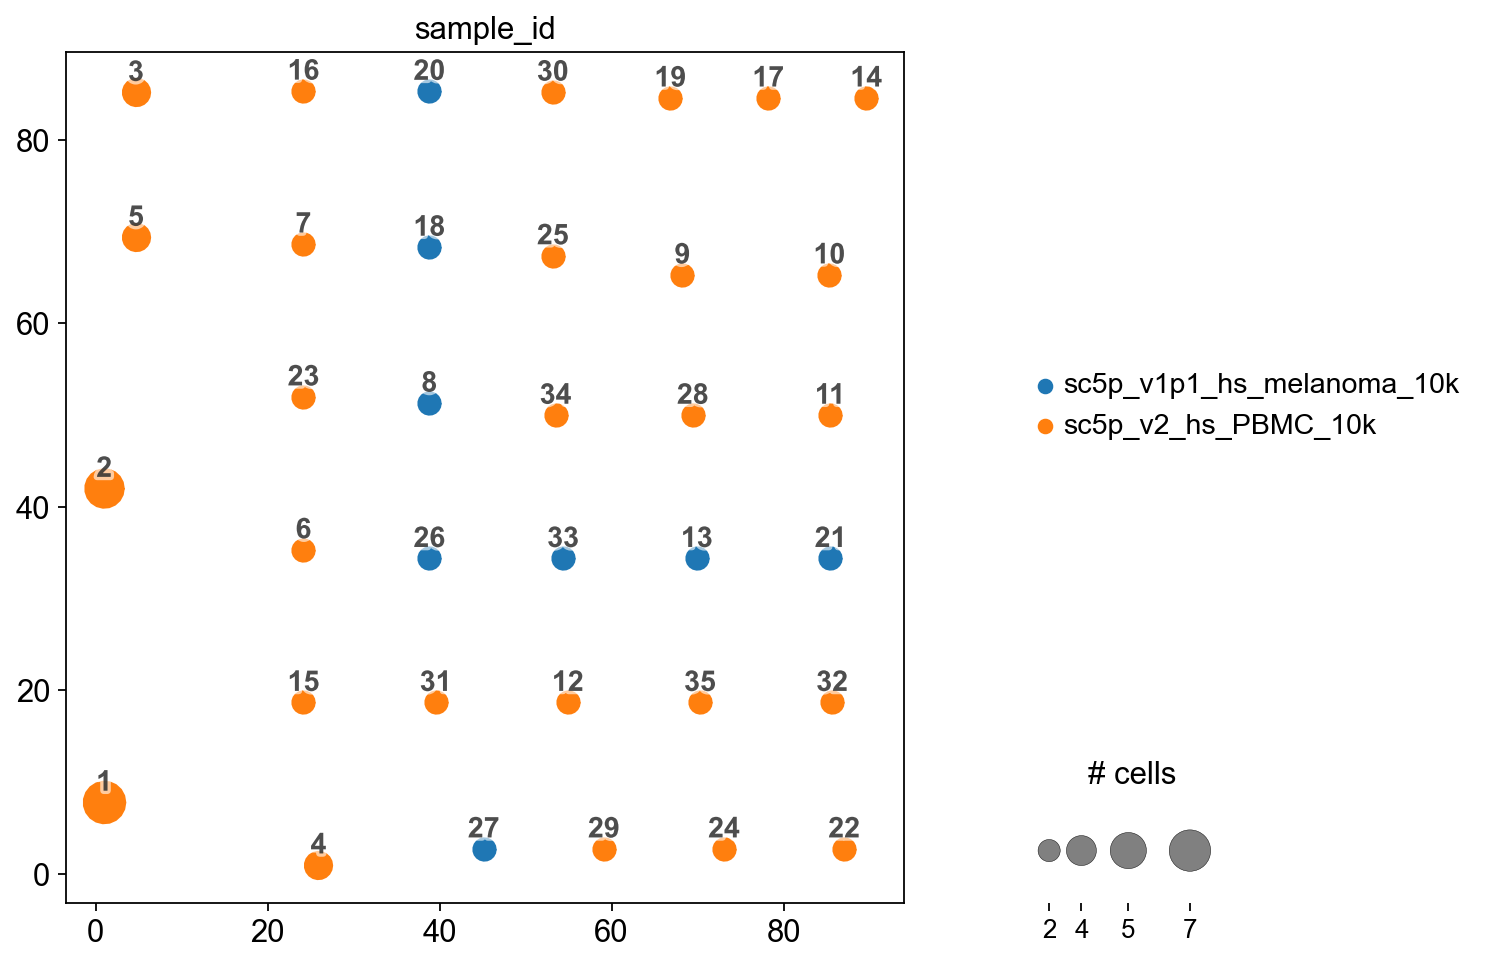

In [39]:
ddl.tl.transfer(adata, vdj, clone_key = 'clone_id_by_size', collapse_nodes = True)
ir.tl.clonotype_network(adata, clonotype_key = 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(adata, color = 'sample_id', panel_size=(7, 7))

**Finish.**

We can save the files.

In [40]:
adata.write('adata_tcr.h5ad', compression = 'gzip')

In [41]:
vdj.write_h5ddl('dandelion_results_tcr.h5ddl', complib = 'blosc:lz4')